<a href="https://colab.research.google.com/github/BrunoSader/WhisperTraining/blob/main/fine_tune_whisper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tune Whisper For Multilingual ASR with 🤗 Transformers

In this Colab, we present a step-by-step guide on how to fine-tune Whisper
for any multilingual ASR dataset using Hugging Face 🤗 Transformers. This is a
more "hands-on" version of the accompanying [blog post](https://huggingface.co/blog/fine-tune-whisper).
For a more in-depth explanation of Whisper, the Common Voice dataset and the theory behind fine-tuning, the reader is advised to refer to the blog post.

## Introduction

Whisper is a pre-trained model for automatic speech recognition (ASR)
published in [September 2022](https://openai.com/blog/whisper/) by the authors
Alec Radford et al. from OpenAI. Unlike many of its predecessors, such as
[Wav2Vec 2.0](https://arxiv.org/abs/2006.11477), which are pre-trained
on un-labelled audio data, Whisper is pre-trained on a vast quantity of
**labelled** audio-transcription data, 680,000 hours to be precise.
This is an order of magnitude more data than the un-labelled audio data used
to train Wav2Vec 2.0 (60,000 hours). What is more, 117,000 hours of this
pre-training data is multilingual ASR data. This results in checkpoints
that can be applied to over 96 languages, many of which are considered
_low-resource_.

When scaled to 680,000 hours of labelled pre-training data, Whisper models
demonstrate a strong ability to generalise to many datasets and domains.
The pre-trained checkpoints achieve competitive results to state-of-the-art
ASR systems, with near 3% word error rate (WER) on the test-clean subset of
LibriSpeech ASR and a new state-of-the-art on TED-LIUM with 4.7% WER (_c.f._
Table 8 of the [Whisper paper](https://cdn.openai.com/papers/whisper.pdf)).
The extensive multilingual ASR knowledge acquired by Whisper during pre-training
can be leveraged for other low-resource languages; through fine-tuning, the
pre-trained checkpoints can be adapted for specific datasets and languages
to further improve upon these results. We'll show just how Whisper can be fine-tuned
for low-resource languages in this Colab.

<figure>
<img src="https://raw.githubusercontent.com/sanchit-gandhi/notebooks/main/whisper_architecture.svg" alt="Trulli" style="width:100%">
<figcaption align = "center"><b>Figure 1:</b> Whisper model. The architecture
follows the standard Transformer-based encoder-decoder model. A
log-Mel spectrogram is input to the encoder. The last encoder
hidden states are input to the decoder via cross-attention mechanisms. The
decoder autoregressively predicts text tokens, jointly conditional on the
encoder hidden states and previously predicted tokens. Figure source:
<a href="https://openai.com/blog/whisper/">OpenAI Whisper Blog</a>.</figcaption>
</figure>

The Whisper checkpoints come in five configurations of varying model sizes.
The smallest four are trained on either English-only or multilingual data.
The largest checkpoints are multilingual only. All 11 of the pre-trained checkpoints
are available on the [Hugging Face Hub](https://huggingface.co/models?search=openai/whisper). The
checkpoints are summarised in the following table with links to the models on the Hub:

| Size     | Layers | Width | Heads | Parameters | English-only                                         | Multilingual                                        |
|----------|--------|-------|-------|------------|------------------------------------------------------|-----------------------------------------------------|
| tiny     | 4      | 384   | 6     | 39 M       | [✓](https://huggingface.co/openai/whisper-tiny.en)   | [✓](https://huggingface.co/openai/whisper-tiny.)    |
| base     | 6      | 512   | 8     | 74 M       | [✓](https://huggingface.co/openai/whisper-base.en)   | [✓](https://huggingface.co/openai/whisper-base)     |
| small    | 12     | 768   | 12    | 244 M      | [✓](https://huggingface.co/openai/whisper-small.en)  | [✓](https://huggingface.co/openai/whisper-small)    |
| medium   | 24     | 1024  | 16    | 769 M      | [✓](https://huggingface.co/openai/whisper-medium.en) | [✓](https://huggingface.co/openai/whisper-medium)   |
| large    | 32     | 1280  | 20    | 1550 M     | x                                                    | [✓](https://huggingface.co/openai/whisper-large)    |
| large-v2 | 32     | 1280  | 20    | 1550 M     | x                                                    | [✓](https://huggingface.co/openai/whisper-large-v2) |
| large-v3 | 32     | 1280  | 20    | 1550 M     | x                                                    | [✓](https://huggingface.co/openai/whisper-large-v3) |


For demonstration purposes, we'll fine-tune the multilingual version of the
[`"small"`](https://huggingface.co/openai/whisper-small) checkpoint with 244M params (~= 1GB).
As for our data, we'll train and evaluate our system on a low-resource language
taken from the [Common Voice](https://huggingface.co/datasets/mozilla-foundation/common_voice_11_0)
dataset. We'll show that with as little as 8 hours of fine-tuning data, we can achieve
strong performance in this language.

------------------------------------------------------------------------

\\({}^1\\) The name Whisper follows from the acronym “WSPSR”, which stands for “Web-scale Supervised Pre-training for Speech Recognition”.

## Prepare Environment

First of all, let's try to secure a decent GPU for our Colab! Unfortunately, it's becoming much harder to get access to a good GPU with the free version of Google Colab. However, with Google Colab Pro one should have no issues in being allocated a V100 or P100 GPU.

To get a GPU, click _Runtime_ -> _Change runtime type_, then change _Hardware accelerator_ from _CPU_ to one of the available GPUs, e.g. _T4_ (or better if you have one available). Next, click `Connect T4` in the top right-hand corner of your screen (or `Connect {V100, A100}` if you selected a different GPU).

We can verify that we've been assigned a GPU and view its specifications:

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri May 30 15:11:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             51W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

We'll employ several popular Python packages to fine-tune the Whisper model.
We'll use `datasets[audio]` to download and prepare our training data, alongside
`transformers` and `accelerate` to load and train our Whisper model.
We'll also require the `soundfile` package to pre-process audio files,
`evaluate` and `jiwer` to assess the performance of our model, and
`tensorboard` to log our metrics. Finally, we'll use `gradio` to build a
flashy demo of our fine-tuned model.

In [ ]:
!pip install --upgrade --quiet pip
!pip install --upgrade --quiet datasets[audio] transformers accelerate evaluate jiwer tensorboard==2.18 gradio
!pip install numba==0.60.0
!pip install pyarabic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 145.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 136.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 135.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 186.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 215.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━ 252.7/664.8 MB 418.3 MB/s eta 0:00:01

We strongly advise you to upload model checkpoints directly the [Hugging Face Hub](https://huggingface.co/)
whilst training. The Hub provides:
- Integrated version control: you can be sure that no model checkpoint is lost during training.
- Tensorboard logs: track important metrics over the course of training.
- Model cards: document what a model does and its intended use cases.
- Community: an easy way to share and collaborate with the community!

Linking the notebook to the Hub is straightforward - it simply requires entering your
Hub authentication token when prompted. Find your Hub authentication token [here](https://huggingface.co/settings/tokens):

In [3]:
from huggingface_hub import notebook_login
#hf _nUozDOLgoglAeCkKiGQuJlwPzEUMRwBRgv
notebook_login()

## Load Dataset

Using 🤗 Datasets, downloading and preparing data is extremely simple.
We can download and prepare the Common Voice splits in just one line of code.

First, ensure you have accepted the terms of use on the Hugging Face Hub: [mozilla-foundation/common_voice_11_0](https://huggingface.co/datasets/mozilla-foundation/common_voice_11_0). Once you have accepted the terms, you will have full access to the dataset and be able to download the data locally.

Since Hindi is very low-resource, we'll combine the `train` and `validation`
splits to give approximately 8 hours of training data. We'll use the 4 hours
of `test` data as our held-out test set:

In [4]:
from datasets import load_dataset, DatasetDict
sada = load_dataset("khaledalganem/sada2022", trust_remote_code=True)

print("\nSADA2022 structure after loading:")
print(sada)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.28k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/123M [00:00<?, ?B/s]

valid.csv:   0%|          | 0.00/2.70M [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/3.18M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/241834 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5139 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6193 [00:00<?, ? examples/s]


SADA2022 structure after loading:
DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'FileName', 'ShowName', 'FullFileLength', 'SegmentID', 'SegmentLength', 'SegmentStart', 'SegmentEnd', 'SpeakerAge', 'SpeakerGender', 'SpeakerDialect', 'Speaker', 'Environment', 'GroundTruthText', 'ProcessedText', 'Category'],
        num_rows: 241834
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'FileName', 'ShowName', 'FullFileLength', 'SegmentID', 'SegmentLength', 'SegmentStart', 'SegmentEnd', 'SpeakerAge', 'SpeakerGender', 'SpeakerDialect', 'Speaker', 'Environment', 'GroundTruthText', 'ProcessedText', 'Category'],
        num_rows: 5139
    })
    test: Dataset({
        features: ['Unnamed: 0', 'FileName', 'ShowName', 'FullFileLength', 'SegmentID', 'SegmentLength', 'SegmentStart', 'SegmentEnd', 'SpeakerAge', 'SpeakerGender', 'SpeakerDialect', 'Speaker', 'Environment', 'GroundTruthText', 'ProcessedText', 'Category'],
        num_rows: 6193
    })
})


In [5]:
sada["train"][0]

{'Unnamed: 0': 0,
 'FileName': 'batch_1/6k_SBA_100_0.wav',
 'ShowName': 'الجفاف يقتل الندى',
 'FullFileLength': 605.3,
 'SegmentID': '6k_SBA_100_0-seg_249_720-251_840',
 'SegmentLength': 2.1200000000000045,
 'SegmentStart': 249.72,
 'SegmentEnd': 251.84,
 'SpeakerAge': 'Elderly -- كبير في السن',
 'SpeakerGender': 'Male',
 'SpeakerDialect': 'Najdi',
 'Speaker': 'Speaker1متحدث',
 'Environment': 'Clean -- نظيف',
 'GroundTruthText': 'ووضّح كلامك يا مغيث',
 'ProcessedText': 'ووضح كلامك يا مغيث',
 'Category': 'درامي'}

In [66]:
from datasets import load_dataset, DatasetDict, concatenate_datasets, Audio
import math

# --- Parameters ---
TARGET_SADA_HOURS = 5
TARGET_CV_HOURS = 5
AVG_CV_SECONDS_PER_SAMPLE = 4 # Estimate, adjust if needed

TARGET_SADA_SECONDS = TARGET_SADA_HOURS * 3600
TARGET_CV_SECONDS = TARGET_CV_HOURS * 3600

# --- SADA Selection (Using SegmentLength for accuracy) ---
print("Loading SADA2022 metadata...")
sada_raw = load_dataset("khaledalganem/sada2022", trust_remote_code=True, split="train")

# Add an index and shuffle
sada_raw = sada_raw.add_column("index", range(len(sada_raw)))
sada_shuffled = sada_raw.shuffle(seed=42)

print(f"Selecting ~{TARGET_SADA_HOURS} hours from SADA...")
selected_indices = []
current_duration = 0.0
for example in sada_shuffled:
    # Check if SegmentLength exists and is valid
    if 'SegmentLength' in example and isinstance(example['SegmentLength'], (int, float)) and example['SegmentLength'] > 0:
        current_duration += example['SegmentLength']
        selected_indices.append(example['index'])
        if current_duration >= TARGET_SADA_SECONDS:
            break
    else:
        # Handle cases where SegmentLength might be missing or invalid, if any
        print(f"Skipping record due to invalid SegmentLength: {example}")

print(f"Selected {len(selected_indices)} samples from SADA, totaling {current_duration / 3600:.2f} hours.")
sada_subset = sada_raw.select(selected_indices)

# --- Common Voice Selection (Using sample count estimate) ---
print(f"Selecting ~{TARGET_CV_HOURS} hours from Common Voice 17...")
num_cv_samples = math.ceil(TARGET_CV_SECONDS / AVG_CV_SECONDS_PER_SAMPLE)

# Split CV samples between train (80%) and test (20%)
num_cv_train = int(num_cv_samples * 0.8)
num_cv_test = num_cv_samples - num_cv_train

print(f"Aiming for {num_cv_train} CV train samples and {num_cv_test} CV test samples.")

cv_train = load_dataset("mozilla-foundation/common_voice_17_0", "ar", split="train+validation", trust_remote_code=True)
cv_test = load_dataset("mozilla-foundation/common_voice_17_0", "ar", split="test", trust_remote_code=True)

# Ensure we don't request more samples than available
num_cv_train = min(num_cv_train, len(cv_train))
num_cv_test = min(num_cv_test, len(cv_test))

cv_train_subset = cv_train.shuffle(seed=42).select(range(num_cv_train))
cv_test_subset = cv_test.shuffle(seed=42).select(range(num_cv_test))

print(f"Selected {len(cv_train_subset)} CV train and {len(cv_test_subset)} CV test samples.")

# Create a DatasetDict for CV
common_voice_subset = DatasetDict({
    "train": cv_train_subset,
    "test": cv_test_subset
})

# Clean CV columns and cast audio (same as before)
common_voice_subset = common_voice_subset.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "path", "segment", "up_votes"])
common_voice_subset = common_voice_subset.cast_column("audio", Audio(sampling_rate=16000))

# --- Process SADA Subset (FIXED - Keep Segment Info) ---
print("Processing SADA subset...")
transcript_col = "GroundTruthText"
if transcript_col not in sada_subset.column_names:
    transcript_col = "transcript" # Fallback

SADA_REPO_ID = "khaledalganem/sada2022"
SADA_BASE_URL = f"https://huggingface.co/datasets/{SADA_REPO_ID}/resolve/main/"

def prepare_sada(batch):
    batch["audio_url"] = SADA_BASE_URL + batch["FileName"]
    batch["sentence"] = batch[transcript_col]
    # ✅ KEEP segment timing info - this is crucial!
    batch["segment_start"] = batch["SegmentStart"]
    batch["segment_end"] = batch["SegmentEnd"]
    batch["segment_length"] = batch["SegmentLength"]
    # Also keep useful metadata
    batch["speaker_dialect"] = batch.get("SpeakerDialect", "Unknown")
    return batch

sada_subset_processed = sada_subset.map(prepare_sada, num_proc=4)

# ✅ FIXED: Keep segment timing columns
columns_to_keep = [
    "audio_url",
    "sentence",
    "segment_start",     # ✅ Keep for audio segmentation
    "segment_end",       # ✅ Keep for audio segmentation
    "segment_length",    # ✅ Keep for validation
    "speaker_dialect"    # ✅ Keep for analysis
]
all_columns = sada_subset_processed.column_names
columns_to_remove = [col for col in all_columns if col not in columns_to_keep]
sada_subset_processed = sada_subset_processed.remove_columns(columns_to_remove)
sada_subset_processed = sada_subset_processed.rename_column("audio_url", "audio")
sada_subset_processed = sada_subset_processed.cast_column("audio", Audio(sampling_rate=16000))

# Split SADA subset into train/test
sada_split = sada_subset_processed.train_test_split(test_size=0.10, seed=42) # 10% test
sada_100h = DatasetDict({
    "train": sada_split["train"],
    "test": sada_split["test"]
})

# --- Add dummy segment info to Common Voice for compatibility ---
def add_dummy_segments(batch):
    # Common Voice doesn't have segments - use full audio
    batch["segment_start"] = 0.0
    batch["segment_end"] = -1.0  # -1 means "use full audio"
    batch["segment_length"] = -1.0
    batch["speaker_dialect"] = "Common_Voice"
    return batch

print("Adding compatibility fields to Common Voice...")
common_voice_subset = common_voice_subset.map(add_dummy_segments)

# --- Combine Datasets ---
print("Combining datasets...")
combined_dataset = DatasetDict()
combined_dataset["train"] = concatenate_datasets([common_voice_subset["train"], sada_100h["train"]])
combined_dataset["test"] = concatenate_datasets([common_voice_subset["test"], sada_100h["test"]])

# --- Shuffle ---
combined_dataset["train"] = combined_dataset["train"].shuffle(seed=42)
combined_dataset["test"] = combined_dataset["test"].shuffle(seed=42)

print("\n--- Final ~100h Combined Dataset ---")
print(combined_dataset)
print(f"Total training examples: {len(combined_dataset['train'])}")
print(f"Total testing examples: {len(combined_dataset['test'])}")

# --- Verify segment info is preserved ---
print("\n🔍 Verifying segment info:")
sample = combined_dataset["train"][0]
print(f"Sample keys: {list(sample.keys())}")
if "segment_start" in sample:
    print(f"✅ Segment info preserved: {sample['segment_start']:.1f}s - {sample['segment_end']:.1f}s")
    print(f"   Dialect: {sample.get('speaker_dialect', 'Unknown')}")
else:
    print("❌ Segment info missing!")

print("\n💡 Now you can use this in prepare_dataset:")
print("   if batch['segment_end'] > 0:  # SADA sample")
print("       # Extract segment")
print("   else:  # Common Voice sample")
print("       # Use full audio")

Loading SADA2022 metadata...
Selecting ~5 hours from SADA...
Selected 2753 samples from SADA, totaling 5.00 hours.
Selecting ~5 hours from Common Voice 17...
Aiming for 3600 CV train samples and 900 CV test samples.
Selected 3600 CV train and 900 CV test samples.
Processing SADA subset...


Map (num_proc=4):   0%|          | 0/2753 [00:00<?, ? examples/s]

Adding compatibility fields to Common Voice...


Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Combining datasets...

--- Final ~100h Combined Dataset ---
DatasetDict({
    train: Dataset({
        features: ['audio', 'sentence', 'variant', 'segment_start', 'segment_end', 'segment_length', 'speaker_dialect'],
        num_rows: 6077
    })
    test: Dataset({
        features: ['audio', 'sentence', 'variant', 'segment_start', 'segment_end', 'segment_length', 'speaker_dialect'],
        num_rows: 1176
    })
})
Total training examples: 6077
Total testing examples: 1176

🔍 Verifying segment info:
Sample keys: ['audio', 'sentence', 'variant', 'segment_start', 'segment_end', 'segment_length', 'speaker_dialect']
✅ Segment info preserved: 50.0s - 52.0s
   Dialect: Hijazi

💡 Now you can use this in prepare_dataset:
   if batch['segment_end'] > 0:  # SADA sample
       # Extract segment
   else:  # Common Voice sample
       # Use full audio


Most ASR datasets only provide input audio samples (`audio`) and the
corresponding transcribed text (`sentence`). Common Voice contains additional
metadata information, such as `accent` and `locale`, which we can disregard for ASR.
Keeping the notebook as general as possible, we only consider the input audio and
transcribed text for fine-tuning, discarding the additional metadata information:

## Prepare Feature Extractor, Tokenizer and Data

The ASR pipeline can be de-composed into three stages:

1. A feature extractor which pre-processes the raw audio-inputs
2. The model which performs the sequence-to-sequence mapping
3. A tokenizer which post-processes the model outputs to text format

In 🤗 Transformers, the Whisper model has an associated feature extractor and tokenizer,
called [WhisperFeatureExtractor](https://huggingface.co/docs/transformers/main/model_doc/whisper#transformers.WhisperFeatureExtractor)
and [WhisperTokenizer](https://huggingface.co/docs/transformers/main/model_doc/whisper#transformers.WhisperTokenizer)
respectively.

We'll go through details for setting-up the feature extractor and tokenizer one-by-one!

### Load WhisperFeatureExtractor

The Whisper feature extractor performs two operations:
1. Pads / truncates the audio inputs to 30s: any audio inputs shorter than 30s are padded to 30s with silence (zeros), and those longer that 30s are truncated to 30s
2. Converts the audio inputs to _log-Mel spectrogram_ input features, a visual representation of the audio and the form of the input expected by the Whisper model

<figure>
<img src="https://raw.githubusercontent.com/sanchit-gandhi/notebooks/main/spectrogram.jpg" alt="Trulli" style="width:100%">
<figcaption align = "center"><b>Figure 2:</b> Conversion of sampled audio array to log-Mel spectrogram.
Left: sampled 1-dimensional audio signal. Right: corresponding log-Mel spectrogram. Figure source:
<a href="https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html">Google SpecAugment Blog</a>.
</figcaption>

We'll load the feature extractor from the pre-trained checkpoint with the default values:

In [2]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-large-v3-turbo")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Load WhisperTokenizer

The Whisper model outputs a sequence of _token ids_. The tokenizer maps each of these token ids to their corresponding text string. For Hindi, we can load the pre-trained tokenizer and use it for fine-tuning without any further modifications. We simply have to
specify the target language and the task. These arguments inform the
tokenizer to prefix the language and task tokens to the start of encoded
label sequences:

In [3]:
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-large-v3-turbo", language="ar", task="transcribe")

### Combine To Create A WhisperProcessor

To simplify using the feature extractor and tokenizer, we can _wrap_
both into a single `WhisperProcessor` class. This processor object
inherits from the `WhisperFeatureExtractor` and `WhisperProcessor`,
and can be used on the audio inputs and model predictions as required.
In doing so, we only need to keep track of two objects during training:
the `processor` and the `model`:

In [4]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained("openai/whisper-large-v3-turbo", language="ar", task="transcribe")

### Prepare Data

Now we can write a function to prepare our data ready for the model:
1. We load and resample the audio data by calling `batch["audio"]`. As explained above, 🤗 Datasets performs any necessary resampling operations on the fly.
2. We use the feature extractor to compute the log-Mel spectrogram input features from our 1-dimensional audio array.
3. We encode the transcriptions to label ids through the use of the tokenizer.

In [67]:
# Alternative: Use your existing dataset with maximum optimization
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["RAYON_RS_NUM_CPUS"] = "1"

# Process in larger batches with memory mapping
def prepare_dataset_ultra_fast(examples):
    """Ultra-fast batch processing"""
    results = {"input_features": [], "labels": []}

    # Process all examples in parallel
    for i in range(len(examples["audio"])):
        try:
            audio = examples["audio"][i]

            # Extract segment efficiently
            if examples.get("segment_end")[i] > 0:
                sr = audio["sampling_rate"]
                start = int(examples["segment_start"][i] * sr)
                end = int(examples["segment_end"][i] * sr)
                audio_array = audio["array"][start:end]
            else:
                audio_array = audio["array"]

            # Batch feature extraction
            features = feature_extractor(
                audio_array,
                sampling_rate=16000,
                return_tensors="np"
            ).input_features[0]

            results["input_features"].append(features)

            # Tokenize
            labels = tokenizer(
                examples["sentence"][i],
                truncation=True,
                max_length=448
            ).input_ids

            results["labels"].append(labels)

        except Exception as e:
            print(f"Error processing sample {i}: {e}")
            # Add dummy data to maintain alignment
            results["input_features"].append(np.zeros((80, 3000)))
            results["labels"].append([0])

    return results

# Use your existing combined_dataset
combined_dataset = combined_dataset.map(
    prepare_dataset_ultra_fast,
    batched=True,
    batch_size=100,  # Large batches
    num_proc=1,  # Single process is often faster for I/O bound tasks
    remove_columns=combined_dataset.column_names["train"],
    desc="Processing audio"
)

Processing audio:   0%|          | 0/6077 [00:00<?, ? examples/s]

Exception ignored from cffi callback <function SoundFile._init_virtual_io.<locals>.vio_read at 0x7b2359368c20>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/soundfile.py", line 1295, in vio_read
    data_read = file.readinto(buf)
                ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fsspec/spec.py", line 2101, in readinto
    data = self.read(out.nbytes)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/datasets/utils/file_utils.py", line 827, in read_with_retries
    out = read(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_file_system.py", line 1015, in read
    return super().read(length)
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fsspec/spec.py", line 2083, in read
    out = self.cache._fetch(self.loc, self.loc + length)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  Fi

LibsndfileError: Error opening <File-like object HfFileSystem, datasets/khaledalganem/sada2022@main/batch_4/6k_v_SBA_237_1.wav>: Format not recognised.

## Full Data Pipeline

In [7]:
from datasets import load_dataset
import requests
from pathlib import Path
from tqdm.auto import tqdm
import os

# Parameters
TARGET_SADA_HOURS = 20  # How many hours of SADA to download
LOCAL_SADA_DIR = "./sada_audio_files/"

print(f"🎯 Goal: Download {TARGET_SADA_HOURS} hours of SADA audio files locally")

# Step 1: Load SADA metadata (fast - no audio)
print("Loading SADA metadata...")
sada_meta = load_dataset("khaledalganem/sada2022", trust_remote_code=True, split="train")

# Step 2: Calculate which files we need
print("Calculating required files...")
total_seconds_needed = TARGET_SADA_HOURS * 3600
current_seconds = 0
files_needed = {}  # filename -> list of segments

for example in tqdm(sada_meta, desc="Scanning segments"):
    if current_seconds >= total_seconds_needed:
        break

    filename = example["FileName"]
    segment_info = {
        'start': example["SegmentStart"],
        'end': example["SegmentEnd"],
        'length': example["SegmentLength"],
        'text': example.get("GroundTruthText", ""),
        'index': example['index'] if 'index' in example else len(files_needed)
    }

    if filename not in files_needed:
        files_needed[filename] = []
    files_needed[filename].append(segment_info)

    current_seconds += example.get("SegmentLength", 0)

print(f"📊 Need {len(files_needed)} unique audio files containing {current_seconds/3600:.1f} hours")

# Step 3: Download files
Path(LOCAL_SADA_DIR).mkdir(exist_ok=True)
SADA_BASE_URL = "https://huggingface.co/datasets/khaledalganem/sada2022/resolve/main/"

downloaded = 0
skipped = 0

for filename in tqdm(files_needed.keys(), desc="Downloading SADA files"):
    local_path = Path(LOCAL_SADA_DIR) / filename

    # Create subdirectories if needed
    local_path.parent.mkdir(parents=True, exist_ok=True)

    # Skip if already exists
    if local_path.exists() and local_path.stat().st_size > 1000:  # Check size to ensure not corrupted
        skipped += 1
        continue

    try:
        # Download
        url = SADA_BASE_URL + filename
        response = requests.get(url, timeout=120, stream=True)
        response.raise_for_status()

        # Save with streaming to handle large files
        with open(local_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)

        downloaded += 1

    except Exception as e:
        print(f"\n❌ Error downloading {filename}: {e}")
        # Remove partial file
        if local_path.exists():
            local_path.unlink()

print(f"\n✅ Download complete! Downloaded: {downloaded}, Skipped: {skipped}")
print(f"📁 Files saved to: {LOCAL_SADA_DIR}")

# Save segment info for faster loading later
import json
segment_info_path = Path(LOCAL_SADA_DIR) / "segment_info.json"
with open(segment_info_path, 'w') as f:
    json.dump(files_needed, f)
print(f"💾 Saved segment info to: {segment_info_path}")

🎯 Goal: Download 1 hours of SADA audio files locally
Loading SADA metadata...
Calculating required files...


Scanning segments:   0%|          | 0/241834 [00:00<?, ?it/s]

📊 Need 12 unique audio files containing 1.0 hours



✅ Download complete! Downloaded: 0, Skipped: 12
📁 Files saved to: ./sada_audio_files/
💾 Saved segment info to: sada_audio_files/segment_info.json


In [30]:
from datasets import load_dataset, DatasetDict, Audio, Dataset, Sequence, concatenate_datasets, Value, Features
import json
from pathlib import Path
import numpy as np
from tqdm.auto import tqdm
import os

# Parameters
TARGET_SADA_HOURS = 20
TARGET_CV_HOURS = 30
LOCAL_SADA_DIR = "./sada_audio_files/"
BATCH_SIZE = 32  # Optimal for A100

print("⚡ Fast dataset loading with direct numpy array storage")

# Fix tokenizer parallelism from the start
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Load SADA segment info
segment_info_path = Path(LOCAL_SADA_DIR) / "segment_info.json"
with open(segment_info_path, 'r') as f:
    sada_files_info = json.load(f)

# Step 1: Create SADA dataset from local files
print(f"\n📂 Creating SADA dataset from {len(sada_files_info)} local files...")

sada_examples = []
total_sada_duration = 0
for filename, segments in sada_files_info.items():
    local_path = Path(LOCAL_SADA_DIR) / filename
    if local_path.exists():
        for seg in segments:
            sada_examples.append({
                'audio': str(local_path),
                'segment_start': float(seg['start']),
                'segment_end': float(seg['end']),
                'segment_length': float(seg['length']),
                'sentence': seg['text'],
                'speaker_dialect': 'SADA'
            })
            total_sada_duration += seg['length']

print(f"Found {len(sada_examples)} SADA segments ({total_sada_duration/3600:.1f} hours)")

# Create SADA dataset
sada_dataset = Dataset.from_list(sada_examples)
sada_dataset = sada_dataset.cast_column("audio", Audio(sampling_rate=16000))

# Step 2: Load Common Voice normally (fast!)
print("\n📥 Loading Common Voice datasets...")

# Calculate samples needed
cv_samples_needed = int(TARGET_CV_HOURS * 3600 / 5)  # ~5s per sample
cv_train_samples = int(cv_samples_needed * 0.95)
cv_test_samples = cv_samples_needed - cv_train_samples

# Load all CV splits
cv_train = load_dataset("mozilla-foundation/common_voice_17_0", "ar", split=f"train[:{cv_train_samples}]", trust_remote_code=True)
cv_val = load_dataset("mozilla-foundation/common_voice_17_0", "ar", split=f"validated[:{cv_train_samples}]", trust_remote_code=True)
cv_test = load_dataset("mozilla-foundation/common_voice_17_0", "ar", split=f"test[:{cv_test_samples*2}]", trust_remote_code=True)

print(f"Loaded CV: {len(cv_train)} train, {len(cv_val)} val, {len(cv_test)} test")

# Step 3: Process Common Voice efficiently
def prepare_cv_for_whisper(dataset, num_samples, split_name):
    """Prepare CV dataset with only needed columns"""
    # Shuffle and select required samples
    dataset = dataset.shuffle(seed=42)
    dataset = dataset.filter(lambda x: bool(x['sentence'].strip()))
    if len(dataset) > num_samples:
        dataset = dataset.select(range(num_samples))

    print(f"Processing {len(dataset)} {split_name} samples...")

    # Remove unnecessary columns first (faster)
    columns_to_keep = ['audio', 'sentence']
    columns_to_remove = [col for col in dataset.column_names if col not in columns_to_keep]
    dataset = dataset.remove_columns(columns_to_remove)

    # Add segment info with FLOAT types to match SADA
    def add_segment_info(example):
        example['segment_start'] = 0.0
        example['segment_end'] = -1.0
        example['segment_length'] = -1.0
        example['speaker_dialect'] = 'Common_Voice'
        return example

    dataset = dataset.map(add_segment_info, desc=f"Adding segment info to {split_name}")

    # Cast audio to 16kHz
    dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

    return dataset

# Process CV datasets
cv_train_processed = prepare_cv_for_whisper(cv_train, cv_train_samples // 2, "CV train")
cv_val_processed = prepare_cv_for_whisper(cv_val, cv_train_samples // 2, "CV val")
cv_test_processed = prepare_cv_for_whisper(cv_test, cv_test_samples, "CV test")

# Combine train and validation
cv_train_full = concatenate_datasets([cv_train_processed, cv_val_processed])

# Step 4: Split SADA and combine with CV
print("\n🔄 Creating final dataset splits...")

# Split SADA 90/10
sada_split = sada_dataset.train_test_split(test_size=0.1, seed=42)

# Combine datasets
train_dataset = concatenate_datasets([sada_split['train'], cv_train_full])
test_dataset = concatenate_datasets([sada_split['test'], cv_test_processed])

# Shuffle final datasets
train_dataset = train_dataset.shuffle(seed=42)
test_dataset = test_dataset.shuffle(seed=42)

print(f"\n📊 Combined dataset:")
print(f"  Train: {len(train_dataset)} samples ({len(sada_split['train'])} SADA + {len(cv_train_full)} CV)")
print(f"  Test: {len(test_dataset)} samples ({len(sada_split['test'])} SADA + {len(cv_test_processed)} CV)")

# Step 5: OPTIMIZED - Process directly to numpy arrays
def process_to_numpy_arrays(dataset, split_name):
    print(f"\n🚀 Processing {split_name} split to numpy arrays...")

    all_input_features = []
    all_labels = []

    batch_size = 16
    total_samples = len(dataset)

    for idx in tqdm(range(0, total_samples, batch_size), desc=f"Processing {split_name}"):
        end_idx = min(idx + batch_size, total_samples)
        batch = dataset[idx:end_idx]

        for i in range(len(batch['audio'])):
            try:
                audio = batch['audio'][i]
                audio_array = np.array(audio['array'], dtype=np.float32)
                sr = audio['sampling_rate']

                if batch['segment_end'][i] > 0:
                    start_sample = int(batch['segment_start'][i] * sr)
                    end_sample = int(batch['segment_end'][i] * sr)
                    audio_array = audio_array[start_sample:end_sample]

                features = feature_extractor( # Assuming feature_extractor is globally defined
                    audio_array,
                    sampling_rate=sr,
                    return_tensors="np"
                )
                all_input_features.append(features.input_features[0])

                tokens = tokenizer( # Assuming tokenizer is globally defined
                    batch['sentence'][i],
                    truncation=True,
                    max_length=448 # Whisper's max length for labels
                )
                all_labels.append(tokens.input_ids)

            except Exception as e:
                print(f"Error processing sample {idx+i}: {str(e)[:100]}") # More context
                # Append a consistent placeholder if error occurs
                # Ensure the placeholder for input_features has the correct number of mel bins (80)
                all_input_features.append(np.zeros((80, 100), dtype=np.float32)) # Small placeholder
                all_labels.append([tokenizer.pad_token_id if tokenizer else 0])


    print(f"Creating dataset from {len(all_input_features)} processed samples...")

    # --- FIX: Define features with large_list for input_features ---
    # 'input_features': Each item is a 2D numpy array (mel_bins, sequence_length).
    #                   This translates to a Sequence of Sequence of floats for Arrow.
    #                   We mark the outer Sequence (the list of all spectrograms) as "large_list".
    # 'labels': Each item is a 1D list of integers (token ids).
    #           This translates to a Sequence of integers.
    defined_features = Features({
        'input_features': Sequence(Sequence(Value("float32")), id="large_list"),
        'labels': Sequence(Value("int32"))
    })
    # -----------------------------------------------------------------

    processed_dataset = Dataset.from_dict({
        'input_features': all_input_features,
        'labels': all_labels
    }, features=defined_features) # Pass the defined features here

    processed_dataset.set_format(type="numpy", columns=["input_features", "labels"])

    return processed_dataset

# Step 6: Process both splits to numpy
print("\n⚡ Processing audio and creating numpy arrays...")

# Process train and test sets
processed_train = process_to_numpy_arrays(train_dataset, "train")
processed_test = process_to_numpy_arrays(test_dataset, "test")

# Create final dataset
combined_dataset = DatasetDict({
    'train': processed_train,
    'test': processed_test
})

print("\n✅ Dataset processing complete!")
print(combined_dataset)

# Verify numpy storage
sample = combined_dataset['train'][0]
print(f"\n📊 Verification:")
print(f"Input features type: {type(sample['input_features'])}")
print(f"Input features dtype: {sample['input_features'].dtype}")
print(f"Input features shape: {sample['input_features'].shape}")

⚡ Fast dataset loading with direct numpy array storage

📂 Creating SADA dataset from 12 local files...
Found 1055 SADA segments (1.0 hours)

📥 Loading Common Voice datasets...
Loaded CV: 684 train, 684 val, 72 test
Processing 342 CV train samples...
Processing 342 CV val samples...
Processing 36 CV test samples...

🔄 Creating final dataset splits...

📊 Combined dataset:
  Train: 1633 samples (949 SADA + 684 CV)
  Test: 142 samples (106 SADA + 36 CV)

⚡ Processing audio and creating numpy arrays...

🚀 Processing train split to numpy arrays...


Processing train:   0%|          | 0/103 [00:00<?, ?it/s]

Creating dataset from 1633 processed samples...

🚀 Processing test split to numpy arrays...


Processing test:   0%|          | 0/9 [00:00<?, ?it/s]

Creating dataset from 142 processed samples...

✅ Dataset processing complete!
DatasetDict({
    train: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 1633
    })
    test: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 142
    })
})

📊 Verification:
Input features type: <class 'numpy.ndarray'>
Input features dtype: float32
Input features shape: (128, 3000)


In [31]:
# Calculate and display total audio hours
print("\n📊 Calculating Audio Duration Statistics...")

# FAST: Use map to get all durations at once
def get_duration(example):
    return {'duration': example['segment_length']}

# Get SADA durations in batch
print("⏱️  Computing SADA durations...")
train_durations = sada_split['train'].map(
    get_duration,
    keep_in_memory=True,
    desc="Getting train durations"
)['duration']

test_durations = sada_split['test'].map(
    get_duration,
    keep_in_memory=True,
    desc="Getting test durations"
)['duration']

# Calculate hours
sada_train_hours = sum(train_durations) / 3600
sada_test_hours = sum(test_durations) / 3600

# CV estimates (5s per sample)
cv_train_hours = len(cv_train_full) * 5 / 3600
cv_test_hours = len(cv_test_processed) * 5 / 3600

# Total hours
total_train_hours = sada_train_hours + cv_train_hours
total_test_hours = sada_test_hours + cv_test_hours

print("\n🎵 Training Set Breakdown:")
print(f"  • SADA: {sada_train_hours:.1f} hours ({len(sada_split['train']):,} segments)")
print(f"  • Common Voice: ~{cv_train_hours:.1f} hours ({len(cv_train_full):,} samples)")
print(f"  • TOTAL: ~{total_train_hours:.1f} hours")

print(f"\n🎵 Test Set Breakdown:")
print(f"  • SADA: {sada_test_hours:.1f} hours ({len(sada_split['test']):,} segments)")
print(f"  • Common Voice: ~{cv_test_hours:.1f} hours ({len(cv_test_processed):,} samples)")
print(f"  • TOTAL: ~{total_test_hours:.1f} hours")

print(f"\n📈 Grand Total: ~{total_train_hours + total_test_hours:.1f} hours of audio data")
print("─" * 50)


📊 Calculating Audio Duration Statistics...
⏱️  Computing SADA durations...


Getting train durations:   0%|          | 0/949 [00:00<?, ? examples/s]

Getting test durations:   0%|          | 0/106 [00:00<?, ? examples/s]


🎵 Training Set Breakdown:
  • SADA: 0.9 hours (949 segments)
  • Common Voice: ~0.9 hours (684 samples)
  • TOTAL: ~1.8 hours

🎵 Test Set Breakdown:
  • SADA: 0.1 hours (106 segments)
  • Common Voice: ~0.1 hours (36 samples)
  • TOTAL: ~0.2 hours

📈 Grand Total: ~2.0 hours of audio data
──────────────────────────────────────────────────


## Training and Evaluation

Now that we've prepared our data, we're ready to dive into the training pipeline.
The [🤗 Trainer](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer)
will do much of the heavy lifting for us. All we have to do is:

- Load a pre-trained checkpoint: we need to load a pre-trained checkpoint and configure it correctly for training.

- Define a data collator: the data collator takes our pre-processed data and prepares PyTorch tensors ready for the model.

- Evaluation metrics: during evaluation, we want to evaluate the model using the [word error rate (WER)](https://huggingface.co/metrics/wer) metric. We need to define a `compute_metrics` function that handles this computation.

- Define the training configuration: this will be used by the 🤗 Trainer to define the training schedule.

Once we've fine-tuned the model, we will evaluate it on the test data to verify that we have correctly trained it
to transcribe speech in Hindi.

### Load a Pre-Trained Checkpoint

We'll start our fine-tuning run from the pre-trained Whisper `small` checkpoint,
the weights for which we need to load from the Hugging Face Hub. Again, this
is trivial through use of 🤗 Transformers!

In [12]:
from transformers import WhisperForConditionalGeneration
import torch

model = WhisperForConditionalGeneration.from_pretrained(
    "openai/whisper-large-v3-turbo",
    torch_dtype=torch.float16,
)

In [13]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params}")
print(f"Total parameters: {total_params}")
print(f"Percentage trainable: {100 * trainable_params / total_params:.2f}%")

Trainable parameters: 806958080
Total parameters: 808878080
Percentage trainable: 99.76%


We can disable the automatic language detection task performed during inference, and force the model to generate in Hindi. To do so, we set the [langauge](https://huggingface.co/docs/transformers/en/model_doc/whisper#transformers.WhisperForConditionalGeneration.generate.language)
and [task](https://huggingface.co/docs/transformers/en/model_doc/whisper#transformers.WhisperForConditionalGeneration.generate.task)
arguments to the generation config. We'll also set any [`forced_decoder_ids`](https://huggingface.co/docs/transformers/main_classes/text_generation#transformers.generation_utils.GenerationMixin.generate.forced_decoder_ids)
to None, since this was the legacy way of setting the language and
task arguments:

In [14]:
model.generation_config.language = "ar"
model.generation_config.task = "transcribe"

model.generation_config.forced_decoder_ids = None

In [15]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model.config.use_cache = False  # Required for gradient checkpointing

# Define LoRA configuration
lora_config = LoraConfig(
    r=64,
    lora_alpha=128,
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj",],
                    #"fc1", "fc2",
                    #"proj_out",
                    #],
    lora_dropout=0.05,
    bias="none",
)

# Apply LoRA to model
model = get_peft_model(model, lora_config)
model.to('cuda')
model.print_trainable_parameters()

trainable params: 19,660,800 || all params: 828,538,880 || trainable%: 2.3729


### Define a Data Collator

The data collator for a sequence-to-sequence speech model is unique in the sense that it
treats the `input_features` and `labels` independently: the  `input_features` must be
handled by the feature extractor and the `labels` by the tokenizer.

The `input_features` are already padded to 30s and converted to a log-Mel spectrogram
of fixed dimension by action of the feature extractor, so all we have to do is convert the `input_features`
to batched PyTorch tensors. We do this using the feature extractor's `.pad` method with `return_tensors=pt`.

The `labels` on the other hand are un-padded. We first pad the sequences
to the maximum length in the batch using the tokenizer's `.pad` method. The padding tokens
are then replaced by `-100` so that these tokens are **not** taken into account when
computing the loss. We then cut the BOS token from the start of the label sequence as we
append it later during training.

We can leverage the `WhisperProcessor` we defined earlier to perform both the
feature extractor and the tokenizer operations:

In [94]:
import torch
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int # Or however you pass this

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # Split inputs and labels
        input_features_list = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features_list, return_tensors="pt")

        # --- MODIFICATION: Explicitly cast input_features to float16 ---
        if "input_features" in batch and batch["input_features"].is_floating_point():
            batch["input_features"] = batch["input_features"].to(torch.float16)
        # --------------------------------------------------------------

        # Get the tokenized label sequences
        label_features_list = [{"input_ids": feature["labels"]} for feature in features]
        labels_batch = self.processor.tokenizer.pad(label_features_list, return_tensors="pt")

        # Replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # If bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        # Ensure decoder_start_token_id is correctly defined and passed
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

Let's initialise the data collator we've just defined:

In [95]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

### Evaluation Metrics

We'll use the word error rate (WER) metric, the 'de-facto' metric for assessing
ASR systems. For more information, refer to the WER [docs](https://huggingface.co/metrics/wer). We'll load the WER metric from 🤗 Evaluate:

In [97]:
import evaluate

metric = evaluate.load("wer")

We then simply have to define a function that takes our model
predictions and returns the WER metric. This function, called
`compute_metrics`, first replaces `-100` with the `pad_token_id`
in the `label_ids` (undoing the step we applied in the
data collator to ignore padded tokens correctly in the loss).
It then decodes the predicted and label ids to strings. Finally,
it computes the WER between the predictions and reference labels:

In [98]:
import unicodedata
import re

def normalize_arabic_for_wer(text):
    """Comprehensive Arabic normalization for WER calculation"""
    if not text:
        return ""

    # Remove diacritics (تشكيل)
    text = unicodedata.normalize('NFD', text)
    text = ''.join(char for char in text if unicodedata.category(char) != 'Mn')

    # Normalize alef variants (أ إ آ → ا)
    text = re.sub(r'[أإآ]', 'ا', text)

    # Normalize alef maksura (ى → ي)
    text = text.replace('ى', 'ي')

    # Normalize teh marbuta (ة → ه)
    text = text.replace('ة', 'ه')

    # Remove tatweel (kashida)
    text = text.replace('ـ', '')

    # Normalize whitespace
    text = ' '.join(text.split())

    # Remove punctuation
    text = re.sub(r'[.,!?؛،؟:\"\'()-]', '', text)

    # Convert to lowercase (if needed for your use case)
    text = text.lower()

    return text.strip()

# Test the function
print("Testing normalization:")
print(f"Original: 'مَرْحَباً بِكَ'")
print(f"Normalized: '{normalize_arabic_for_wer('مَرْحَباً بِكَ')}'")
print(f"Original: 'الطَّائِرة'")
print(f"Normalized: '{normalize_arabic_for_wer('الطَّائِرة')}'")

Testing normalization:
Original: 'مَرْحَباً بِكَ'
Normalized: 'مرحبا بك'
Original: 'الطَّائِرة'
Normalized: 'الطايره'


In [99]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # Replace -100 with pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # Decode predictions and labels
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    # Apply Arabic normalization BEFORE filtering
    pred_str = [normalize_arabic_for_wer(p) for p in pred_str]
    label_str = [normalize_arabic_for_wer(l) for l in label_str]

    # Filter out empty references to avoid jiwer error
    filtered_preds = []
    filtered_labels = []

    for pred, label in zip(pred_str, label_str):
        # Skip if reference is empty after stripping
        if label.strip():
            filtered_preds.append(pred)
            filtered_labels.append(label)
        else:
            # Or add a placeholder
            filtered_preds.append(pred if pred.strip() else "[EMPTY]")
            filtered_labels.append("[EMPTY]")

    # Calculate WER only on non-empty samples
    if filtered_labels:
        wer = 100 * metric.compute(predictions=filtered_preds, references=filtered_labels)
    else:
        wer = 100.0  # Default if all empty

    return {"wer": wer}

### Define the Training Configuration

In the final step, we define all the parameters related to training. For more detail on the training arguments, refer to the Seq2SeqTrainingArguments [docs](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Seq2SeqTrainingArguments).

In [126]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [100]:
from transformers import Seq2SeqTrainingArguments

drive_output_dir = "/content/drive/MyDrive/whisper-large-v3-ar-80h"
# Give your model a specific name on the Hub
hub_repo_name = "Bruno7/whisper-large-v3-turbo-ar-sa-tuned" # <--- CHANGE THIS!

training_args = Seq2SeqTrainingArguments(
    output_dir=drive_output_dir,
    hub_model_id=hub_repo_name,  # The name for your model on the Hub

    # --- Batch Size & Steps ---
    per_device_train_batch_size=8,  # A100 40GB can often handle more, especially with LoRA, but this is a safe start.
    gradient_accumulation_steps=8,  # Effective batch size of 64. Good balance.
    learning_rate=5.5e-5,          #for LoRA.
    warmup_steps=100,
    weight_decay=0.01,
    num_train_epochs=5,

    # --- Performance & Memory ---
    torch_compile=False,             # Excellent for A100 speed.
    gradient_checkpointing=True,    # Essential for saving memory with large models.
    fp16=True,                      # Best for A100 speed & memory.
    fp16_full_eval=True,
    # bf16=False,                   # Correctly False if fp16 is True.
    tf32=True,                      # Leverages A100 Tensor Cores.

    # --- CRITICAL DATA LOADING CHANGES ---
    dataloader_num_workers=8,       # <-- SIGNIFICANT CHANGE: Was 0. Set to a positive number (e.g., 4, 8, 12 based on CPU cores)
                                    # This enables parallel data loading, preventing CPU bottleneck and GPU starvation.
                                    # 0 means data is loaded in the main process, which is very slow.
    dataloader_pin_memory=True,     # <-- SIGNIFICANT CHANGE: Was False. Set to True.
                                    # Speeds up CPU to GPU data transfer by pinning memory.
    dataloader_prefetch_factor=2, # Can uncomment if using num_workers > 0, helps prefetch batches.
    dataloader_persistent_workers=True, # Can uncomment if using num_workers > 0, keeps workers alive.

    group_by_length=False,          # Your setting: Kept False as you had issues previously.
                                    # If stable, True can sometimes improve efficiency by minimizing padding.
    optim="adamw_torch_fused",      # Good, modern, and fast optimizer.

    # --- Evaluation & Saving ---
    do_eval=True,
    save_strategy="steps",
    eval_strategy="steps",
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    generation_max_length=150,
    save_steps=50,
    eval_steps=10,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,

    # --- Reporting & Hub ---
    report_to=["tensorboard"],
    push_to_hub=True,
    logging_first_step=True,
    save_total_limit=3,
    # ddp_find_unused_parameters=False, # Correctly commented out for single-GPU.
)

**Note**: if one does not want to upload the model checkpoints to the Hub,
set `push_to_hub=False`.

We can forward the training arguments to the 🤗 Trainer along with our model,
dataset, data collator and `compute_metrics` function:

In [101]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=combined_dataset["train"],
    eval_dataset=combined_dataset["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)

<ipython-input-101-92acfcb4ac2b>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
No label_names provided for model class `PeftModel`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [102]:
import torch
import time
import numpy as np

print("=== A100 PERFORMANCE DIAGNOSTIC ===\n")

# 1. Check GPU
print(f"GPU: {torch.cuda.get_device_name()}")
print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
print(f"CUDA: {torch.version.cuda}")
print(f"PyTorch: {torch.__version__}\n")

# 2. Check current memory usage
print(f"Memory Allocated: {torch.cuda.memory_allocated() / 1e9:.1f} GB")
print(f"Memory Reserved: {torch.cuda.memory_reserved() / 1e9:.1f} GB")
print(f"Free Memory: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_reserved()) / 1e9:.1f} GB\n")

# 3. Test data loading speed
print("Testing data loading speed...")
start = time.time()
for i, batch in enumerate(trainer.get_train_dataloader()):
    if i >= 10:
        break
data_time = (time.time() - start) / 10
print(f"Average batch load time: {data_time:.3f}s")
print(f"Data loading speed: {1/data_time:.1f} batches/sec\n")

# 4. Test model forward pass
print("Testing model forward pass...")
model.eval()
with torch.no_grad():
    # Get a sample batch
    batch = next(iter(trainer.get_train_dataloader()))
    batch = {k: v.to('cuda') for k, v in batch.items() if isinstance(v, torch.Tensor)}

    # Time forward pass
    torch.cuda.synchronize()
    start = time.time()
    for _ in range(5):
        outputs = model(**batch)
    torch.cuda.synchronize()
    forward_time = (time.time() - start) / 5

print(f"Average forward pass time: {forward_time:.3f}s")
print(f"Forward pass speed: {1/forward_time:.1f} batches/sec\n")

# 5. Check batch sizes
print(f"Train batch size: {trainer.args.per_device_train_batch_size}")
print(f"Gradient accumulation: {trainer.args.gradient_accumulation_steps}")
print(f"Effective batch size: {trainer.args.per_device_train_batch_size * trainer.args.gradient_accumulation_steps}")

# 6. Check for CPU bottlenecks
print(f"\nDataloader workers: {trainer.args.dataloader_num_workers}")
print(f"Pin memory: {trainer.args.dataloader_pin_memory}")

# 7. Test if we're CPU bound
import psutil
print(f"\nCPU count: {psutil.cpu_count()}")
print(f"CPU usage: {psutil.cpu_percent(interval=1)}%")

=== A100 PERFORMANCE DIAGNOSTIC ===

GPU: NVIDIA A100-SXM4-40GB
Memory: 42.5 GB
CUDA: 12.4
PyTorch: 2.6.0+cu124

Memory Allocated: 2.3 GB
Memory Reserved: 3.9 GB
Free Memory: 38.5 GB

Testing data loading speed...
Average batch load time: 0.214s
Data loading speed: 4.7 batches/sec

Testing model forward pass...
Average forward pass time: 0.201s
Forward pass speed: 5.0 batches/sec

Train batch size: 8
Gradient accumulation: 8
Effective batch size: 64

Dataloader workers: 8
Pin memory: True

CPU count: 12
CPU usage: 0.7%


We'll save the processor object once before starting training. Since the processor is not trainable, it won't change over the course of training:

In [103]:
processor.save_pretrained(training_args.output_dir)

[]

### Training

Training will take approximately 5-10 hours depending on your GPU or the one
allocated to this Google Colab. If using this Google Colab directly to
fine-tune a Whisper model, you should make sure that training isn't
interrupted due to inactivity. A simple workaround to prevent this is
to paste the following code into the console of this tab (_right mouse click_
-> _inspect_ -> _Console tab_ -> _insert code_).

```javascript
function ConnectButton(){
    console.log("Connect pushed");
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
}
setInterval(ConnectButton, 60000);
```

The peak GPU memory for the given training configuration is approximately 15.8GB.
Depending on the GPU allocated to the Google Colab, it is possible that you will encounter a CUDA `"out-of-memory"` error when you launch training.
In this case, you can reduce the `per_device_train_batch_size` incrementally by factors of 2
and employ [`gradient_accumulation_steps`](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Seq2SeqTrainingArguments.gradient_accumulation_steps)
to compensate.

To launch training, simply execute:

In [40]:
# Colab keep-alive (prevents timeout)
import IPython
from google.colab import drive

# JavaScript to click in the background
js_code = '''
function ClickConnect(){
    console.log("Keeping Colab alive...");
    document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect, 60000)
'''

display(IPython.display.Javascript(js_code))
print("✅ Keep-alive enabled - Colab won't timeout")

# Also mount drive with better error handling
try:
    drive.mount('/content/drive', force_remount=True)
    print("✅ Drive mounted successfully")
except:
    print("⚠️ Drive mounting failed - checkpoints won't be saved!")

<IPython.core.display.Javascript object>

✅ Keep-alive enabled - Colab won't timeout
Mounted at /content/drive
✅ Drive mounted successfully


In [104]:
import time
import torch
import gc
import os
from transformers.trainer_callback import TrainerCallback

# before starting
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True
torch.cuda.empty_cache()

# Check for existing checkpoints (resume training)
checkpoints = [d for d in os.listdir(drive_output_dir) if d.startswith('checkpoint-')]
checkpoints = False
if checkpoints:
    latest_checkpoint = max(checkpoints, key=lambda x: int(x.split('-')[1]))
    resume_from = os.path.join(drive_output_dir, latest_checkpoint)
    print(f"🔄 Resuming from checkpoint: {resume_from}")
else:
    resume_from = None
    print("🆕 Starting fresh training")

# Training with error handling
print("\n🚀 Training starting...")
start_time = time.time()

try:
    # Train (will auto-resume if checkpoint exists)
    trainer.train(resume_from_checkpoint=resume_from)

    # Calculate final stats
    total_time = time.time() - start_time
    print(f"\n✅ Training completed successfully!")
    print(f"   Total time: {total_time/3600:.1f} hours ({total_time:.1f} seconds)")

except KeyboardInterrupt:
    print("\n⚠️ Training interrupted by user")
    print("Saving checkpoint...")
    trainer.save_model(os.path.join(drive_output_dir, "checkpoint-interrupted"))
    print("✅ Checkpoint saved. You can resume later.")

finally:
    # Always save the training log
    if hasattr(trainer.state, 'log_history'):
        import json
        log_file = os.path.join(drive_output_dir, "training_log.json")
        with open(log_file, 'w') as f:
            json.dump(trainer.state.log_history, f, indent=2)
        print(f"\n📊 Training log saved to {log_file}")

# Quick evaluation on best model
print("\n🔍 Loading best model for final evaluation...")
trainer.model = trainer.model.from_pretrained(drive_output_dir)
final_metrics = trainer.evaluate()
print(f"📈 Final evaluation WER: {final_metrics.get('eval_wer', 'N/A'):.2f}%")

🆕 Starting fresh training

🚀 Training starting...


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss,Validation Loss,Wer
10,0.645400,0.820328,46.255924
20,0.637000,0.817441,46.161137
30,0.557700,0.814129,45.971564
40,0.641700,0.808990,46.445498
50,0.619600,0.803446,46.066351
60,0.637900,0.798405,46.066351
70,0.615500,0.791085,45.402844
80,0.529700,0.786393,45.023697
90,0.576100,0.785746,44.360190
100,0.584200,0.778051,44.739336


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(



✅ Training completed successfully!
   Total time: 0.2 hours (568.3 seconds)

📊 Training log saved to /content/drive/MyDrive/whisper-large-v3-ar-80h/training_log.json


ValueError: Unknown format code 'f' for object of type 'str'

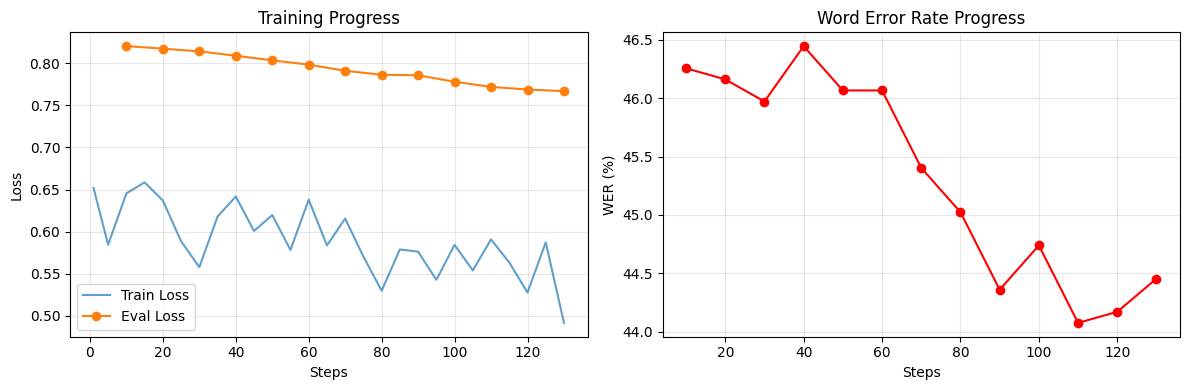


📊 Training Summary:
Initial Loss: 0.6518 → Final Loss: 0.4915
Initial WER: 46.3% → Final WER: 44.5%
Best WER: 44.1% at step 110


In [105]:
# Analyze training results
import matplotlib.pyplot as plt
import json

# Load training history
log_file = os.path.join(drive_output_dir, "training_log.json")
with open(log_file, 'r') as f:
    history = json.load(f)

# Extract metrics
steps = [h['step'] for h in history if 'loss' in h]
train_loss = [h['loss'] for h in history if 'loss' in h]
eval_steps = [h['step'] for h in history if 'eval_loss' in h]
eval_loss = [h['eval_loss'] for h in history if 'eval_loss' in h]
eval_wer = [h['eval_wer'] for h in history if 'eval_wer' in h]

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
ax1.plot(steps, train_loss, label='Train Loss', alpha=0.7)
ax1.plot(eval_steps, eval_loss, label='Eval Loss', marker='o')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss')
ax1.set_title('Training Progress')
ax1.legend()
ax1.grid(True, alpha=0.3)

# WER plot
ax2.plot(eval_steps, eval_wer, label='WER', marker='o', color='red')
ax2.set_xlabel('Steps')
ax2.set_ylabel('WER (%)')
ax2.set_title('Word Error Rate Progress')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(drive_output_dir, 'training_curves.png'), dpi=150)
plt.show()

print(f"\n📊 Training Summary:")
print(f"Initial Loss: {train_loss[0]:.4f} → Final Loss: {train_loss[-1]:.4f}")
print(f"Initial WER: {eval_wer[0]:.1f}% → Final WER: {eval_wer[-1]:.1f}%")
print(f"Best WER: {min(eval_wer):.1f}% at step {eval_steps[eval_wer.index(min(eval_wer))]}")

Our best WER is 32.0% - not bad for 8h of training data! We can make our model more accessible on the Hub with appropriate tags and README information.
You can change these values to match your dataset, language and model
name accordingly:

In [ ]:
kwargs = {
    "dataset_tags": "mozilla-foundation/common_voice_17_0",
    "dataset": "Common Voice 17.0",  # a 'pretty' name for the training dataset
    "dataset_args": "config: ar, split: test",
    "language": "ar",
    "model_name": "Whisper Large v3 ar",  # a 'pretty' name for our model
    "finetuned_from": "openai/whisper-large-v3",
    "tasks": "automatic-speech-recognition",
}

The training results can now be uploaded to the Hub. To do so, execute the `push_to_hub` command and save the preprocessor object we created:

In [ ]:
trainer.push_to_hub(**kwargs)

## Building a Demo

Now that we've fine-tuned our model we can build a demo to show
off its ASR capabilities! We'll make use of 🤗 Transformers
`pipeline`, which will take care of the entire ASR pipeline,
right from pre-processing the audio inputs to decoding the
model predictions.

Running the example below will generate a Gradio demo where we
can record speech through the microphone of our computer and input it to
our fine-tuned Whisper model to transcribe the corresponding text:

In [ ]:
from transformers import pipeline
import gradio as gr

pipe = pipeline(model="brunosader/whisper-large-v3-ar")  # change to "your-username/the-name-you-picked"

def transcribe(audio):
    text = pipe(audio)["text"]
    return text

iface = gr.Interface(
    fn=transcribe,
    inputs=gr.Audio(source="microphone", type="filepath"),
    outputs="text",
    title="Whisper Large Arabic",
    description="Realtime demo for Arabic speech recognition using a fine-tuned Whisper large model.",
)

iface.launch()

## Closing Remarks

In this blog, we covered a step-by-step guide on fine-tuning Whisper for multilingual ASR
using 🤗 Datasets, Transformers and the Hugging Face Hub. For more details on the Whisper model, the Common Voice dataset and the theory behind fine-tuning, refere to the accompanying [blog post](https://huggingface.co/blog/fine-tune-whisper). If you're interested in fine-tuning other
Transformers models, both for English and multilingual ASR, be sure to check out the
examples scripts at [examples/pytorch/speech-recognition](https://github.com/huggingface/transformers/tree/main/examples/pytorch/speech-recognition).